# Creating a custom slice

This code can be run in parallel. To do that, please first start ```ipcluster```, on linux you write the following into the terminal, note that you should be in the ```Snudda/examples/notebook``` directory:

```
export IPYTHONDIR="`pwd`/.ipython"
export IPYTHON_PROFILE=default
ipcluster start 
```

These commands are in ```start_ipcluster.sh``` in the ```examples/notebook``` directory. After starting ipcluster give it a few seconds to get fully up and running before proceeding with the rest of the commands in this notebook. 

If you restart the run you might need to do:

```
ipcluster stop
ipcluster start
```

For instructions how to install and activate ipyparallel for your notebook see 
https://github.com/ipython/ipyparallel

In [1]:
import os

os.environ["IPYTHONDIR"] = ".ipython"
os.environ["IPYTHON_PROFILE"] = "default"

In [2]:
import os

network_path = os.path.join("networks", "slice_example")
mesh_file = os.path.join(network_path, "mesh", "slice.obj")

if not os.path.exists(os.path.dirname(mesh_file)):
    os.makedirs(os.path.dirname(mesh_file))
    

Create a custom slice that is 1000x1000x25 micrometers in size.

In [3]:
from snudda.place import create_slice_mesh
create_slice_mesh(file_name=mesh_file,
                  centre_point=[0.0, 0.0, 0.0],
                  x_len=1e-3,
                  y_len=1e-3,
                  z_len=25e-6,
                  description="This is a test slice corresponding to Allen Institute data")

Creating slice mesh
File: networks/slice_example/mesh/slice.obj
Centre: [0. 0. 0.]
Sides: 0.001 x 0.001 x 2.5e-05
Description: This is a test slice corresponding to Allen Institute data


Here we populate the slice with dSPN and iSPN neurons.

First we ```define_structure```, specifying ```struct_name``` and the ```struct_mesh``` which is a [wavefront obj file](https://en.wikipedia.org/wiki/Wavefront_.obj_file). The ```d_min``` parameter (SI units, so meters) specify how close neurons can be placed. The ```mesh_bin_width``` is voxelisation of the mesh, and it needs to be larger than 2*```d_min```.

Next we ```add_neurons```, passing ```name``` of the neuron, ```volume_id``` it belongs to, and the ```neuron_dir``` where the neurons are located. Note that each dSPN neuron morphology has its own folder, so point to the parent folder e.g. data/neurons/dspn.

The next step is ```add_neuron_target``` which specifies how neurons are coupled together. The connection is from ```neuron_name``` to ```target_name``` of type ```connection_type``` (here GABA). 

The ```dist_pruning``` is optional, and allows us to form preferentially proximal or distal synapses. In this example ```"1-exp(-(0.4*d/60e-6)**2)"``` will result in distal synapses (```d``` is the dendritic distance from the soma). We also specify the pruning parameters ```f1``` (probability of keeping a synapse), ```soft_max``` (a soft upper limit on the number of synapses between connected pairs), ```mu2``` (a soft lower limit on the number of synapses between connected pairs) and ```a3``` (fraction of all connected pairs that we keep, this is useful for changing connection probability without affecting the number of synapses between connected pairs).

The ```conductance``` has two values, the mean and standard deviation. The ```parameter_file``` specifies parameters for the synapse which is moddeled by ```mod_file```. You can also specify additional synapse parameters using the ```channel_param_dictionary```.

Finally we need to write the config file.

In [4]:
from snudda import SnuddaInit

cnc = SnuddaInit(network_path=network_path)

# d_min normally 15e-6, here set to 12e-6 because slice is only 25 micrometers, 2*d_min < mesh_bin_width
cnc.define_structure(struct_name="SliceExample", struct_mesh=mesh_file, d_min=12e-6, mesh_bin_width=25e-6)
cnc.add_neurons(name="dSPN", num_neurons=1000, volume_id="SliceExample",
                neuron_dir=os.path.join("$DATA","neurons","striatum","dspn"))
cnc.add_neurons(name="iSPN", num_neurons=1000, volume_id="SliceExample",
                neuron_dir=os.path.join("$DATA","neurons","striatum","ispn"))

SPN2SPNdistDepPruning = "1-exp(-(0.4*d/60e-6)**2)"

MSD1gGABA = [0.24e-9, 0.1e-9]
MSD2gGABA = [0.24e-9, 0.1e-9]

MSD1GABAfailRate = 0.7  # Taverna 2008, figure 2
MSD2GABAfailRate = 0.4  # Taverna 2008, 2mM

pfdSPNdSPN = os.path.join("$DATA", "synapses", "striatum", "PlanertFitting-DD-tmgaba-fit.json")
pfdSPNiSPN = os.path.join("$DATA", "synapses", "striatum", "PlanertFitting-DI-tmgaba-fit.json")
pfiSPNdSPN = os.path.join("$DATA", "synapses", "striatum", "PlanertFitting-ID-tmgaba-fit.json")
pfiSPNiSPN = os.path.join("$DATA", "synapses", "striatum", "PlanertFitting-II-tmgaba-fit.json")

cnc.add_neuron_target(neuron_name="dSPN",
                       target_name="dSPN",
                       connection_type="GABA",
                       dist_pruning=SPN2SPNdistDepPruning,
                       f1=0.38, soft_max=3, mu2=2.4,
                       a3=1.0,
                       conductance=MSD1gGABA,
                       parameter_file=pfdSPNdSPN,
                       mod_file="tmGabaA",
                       channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                                 "tau2": (12.4e-3, 1e3),
                                                 "failRate": MSD1GABAfailRate})


cnc.add_neuron_target(neuron_name="dSPN",
                       target_name="iSPN",
                       connection_type="GABA",
                       dist_pruning=SPN2SPNdistDepPruning,
                       f1=0.20, soft_max=3, mu2=2.4,
                       a3=1.0,
                       conductance=MSD1gGABA,
                       parameter_file=pfdSPNiSPN,
                       mod_file="tmGabaA",
                       channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                                 "tau2": (12.4e-3, 1e3),
                                                 "failRate": MSD1GABAfailRate})


cnc.add_neuron_target(neuron_name="iSPN",
                       target_name="dSPN",
                       connection_type="GABA",
                       dist_pruning=SPN2SPNdistDepPruning,
                       f1=0.3, soft_max=4, mu2=2.4,
                       a3=1.0,
                       conductance=MSD2gGABA,
                       parameter_file=pfiSPNdSPN,
                       mod_file="tmGabaA",
                       channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                                 "tau2": (12.4e-3, 1e3),
                                                 "failRate": MSD2GABAfailRate})

cnc.add_neuron_target(neuron_name="iSPN",
                       target_name="iSPN",
                       connection_type="GABA",
                       dist_pruning=SPN2SPNdistDepPruning,
                       f1=0.55, soft_max=4, mu2=2.4,
                       a3=1.0,
                       conductance=MSD2gGABA,
                       parameter_file=pfiSPNiSPN,
                       mod_file="tmGabaA",
                       channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                                 "tau2": (12.4e-3, 1e3),
                                                 "failRate": MSD2GABAfailRate})

cnc.write_json()

Adding neurons: dSPN from dir $DATA/neurons/striatum/dspn
Adding neurons: iSPN from dir $DATA/neurons/striatum/ispn
Writing networks/slice_example/network-config.json


In [5]:
# Run place, detect and prune in parallel by passing rc
from ipyparallel import Client
u_file = os.path.join(".ipython", "profile_default", "security", "ipcontroller-client.json")
rc = Client(url_file=u_file, timeout=120, debug=False)
d_view = rc.direct_view(targets='all')  # rc[:] # Direct view into clients

In [6]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, verbose=False, rc=rc)
sp.parse_config()
sp.write_data()

This plots the network, here we leave out axons and dendrites in the figure. Note that matplotlib will distort the axis in 3D plots, causing somas to not appear as spheres.

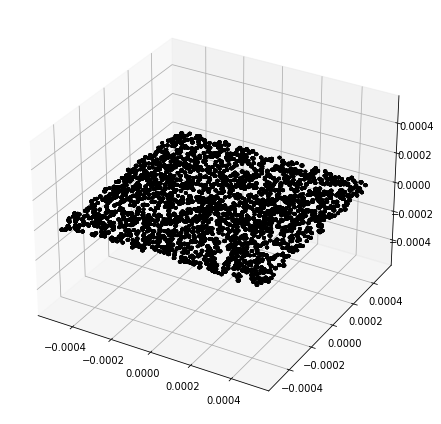

In [7]:
from snudda.plotting import PlotNetwork
network_file = os.path.join(network_path, "network-neuron-positions.hdf5")
pn = PlotNetwork(network_file)
pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False)
pn.close() 

The below step is slow in serial. If you want to run the touch detection in parallel, look at the ```simple_network_parallel.ipynb``` example.

For completion, let us do detection and pruning also. Note that we have chosen to specify ```hyper_voxel_size``` in this example, default value is 100. Larger values will take more memory but should be a bit faster, especially if running in serial mode. If your computer runs out of memory, reduce the ```hyper_voxel_size```.

In [8]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, hyper_voxel_size=100, rc=rc)
sd.detect()

importing SnuddaDetect from snudda.detect.detect on engine(s)
HyperID 69 completed - 281316 synapses found (226.1 s)
HyperID 65 completed - 390585 synapses found (249.9 s)
HyperID 97 completed - 350783 synapses found (328.1 s)
HyperID 93 completed - 365729 synapses found (363.8 s)
HyperID 37 completed - 276995 synapses found (227.0 s)
HyperID 61 completed - 278960 synapses found (241.7 s)
HyperID 64 completed - 7448 synapses found (175.7 s)
HyperID 89 completed - 276024 synapses found (218.6 s)
HyperID 41 completed - 286248 synapses found (191.1 s)
HyperID 92 completed - 5101 synapses found (150.3 s)
HyperID 68 completed - 3661 synapses found (130.8 s)
HyperID 96 completed - 4833 synapses found (135.9 s)
HyperID 36 completed - 4296 synapses found (118.8 s)
HyperID 33 completed - 178690 synapses found (165.9 s)
HyperID 121 completed - 79122 synapses found (123.6 s)
HyperID 60 completed - 3781 synapses found (128.8 s)
HyperID 40 completed - 2866 synapses found (125.4 s)
HyperID 88 comple

In [9]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path, rc=rc)
sp.prune()

importing SnuddaPrune from snudda.detect.prune on engine(s)
prune_synapses_parallel: No gapJunctions skipping pruning
Synapses before pruning: 3333887
Synapses after pruning: 183239 (5.5 % kept)
No gap junctions to prune.


For simplicity this notebook is written using serial execution, please see ```simple_network_parallel.ipynb``` for instructions how to make detection and pruning in parallel.

Snudda place generates ```examples/notebooks/networks/slice_example/network-neuron-positions.hdf5``` which contains the neuron positions. In the same folder prune creates ```network-synapses.hdf5``` which is the finished network with synapses. To load the data have a look at ```SnuddaLoad``` in ```load.py```.